# 1. Introduction

VaR (Value-at-Risk) and ES (Expected shortfall) are simple market risk measures. This project aims to shed some lights on how to estimate these measures in practice using numerous approaches. This study is based on the daily return of the CAC40 index from 2017-2019 (3 years).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("H:/Downloads/CAC_17-19.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index(data['Date'], inplace = True)

data.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(method = 'ffill')

data['ret'] = np.log(data['Adj Close']) - np.log(data['Adj Close']).shift(1)

loss = - data.ret.dropna()

result = pd.DataFrame(columns = ['method', 'VaR', 'ES'])

# 1. Various calculation methods for VaR & ES

VaR at 99% at a one-day horizon using different methods; its interpretation is that the propability of having a loss over $VaR_{0.99}$ at any given day is 1%. ES is an alternative to VaR that is more sensitive to the shape of the tail of the loss distribution. It is defined to be the mean loss of portfolio value given that a loss is occurring at or above the $\alpha$-quantile.

### Empirical quantile method
The method is straightforward: VaR is taken as the value at 99th-percentile of the loss empirical distribution given the dataset. The drawback of this method is that it equalises weights to each observation and that the distribution is discrete rather than continuous while the latter shoule be more preferable. Moreover, this method requires a large dataset, often >> $1/(1-\alpha)$. ES is calculated from the formula:
\begin{equation}
    ES_\alpha = E\big[loss \big| loss \geq VaR_\alpha\big]
    \tag{1}
\end{equation}

Given very high confidence level, for example $\alpha = 0.9999$, this method would produce bias results due to lack of observations.

In [2]:
def VaR_quantile(X, alpha):
    return np.quantile(X, alpha, interpolation = 'linear')

def ES_quantile(X, alpha):
    var_q = VaR_quantile(X, alpha)
    return X[X >= var_q].mean()

method    empirical
VaR        0.020694
ES         0.026793
Name: 0, dtype: object


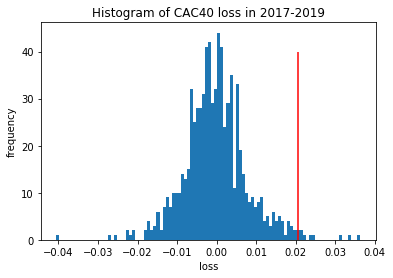

In [3]:
alpha = 0.99

result = result.append(pd.DataFrame([['empirical', VaR_quantile(loss, alpha), ES_quantile(loss, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result.iloc[-1,:])

(no, bins, patches) = plt.hist(loss, bins = 100)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.title('Histogram of CAC40 loss in 2017-2019')
plt.vlines(VaR_quantile(loss, alpha), ymin = 0, ymax = 40, color = 'red')

### Parametric distribution

The method relies on a specific assumption on the log-return distribution $r_t$, Gaussian distribution is usually taken for granted in this case. Knowing the mean $\mu$ and standard deviation $\sigma$ of this distribution results in the estimation for VaR at its 1st-percentile. From the dataset, $\mu$ and $\sigma$ are again deduced using the 1-year rolling window and VaR is infered from the assumed distribution.
\begin{equation}
    VaR_\alpha = \mu + \sigma\mathcal{N}^{-1}(\alpha)
    \tag{2.1}
\end{equation}
Consequently, ES has the closed-form formula as follows:
\begin{equation}
    ES_\alpha = \mu + \dfrac{\sigma}{1 - \alpha} \dfrac{1}{\sqrt{2\pi}} exp\Big(-\big(\mathcal{N}^{-1}(\alpha)\big)^2/2\Big)
    \tag{2.2}
\end{equation}

In [4]:
def VaR_Gaussian(X, alpha):
    from scipy.special import erfinv
    return X.mean() + X.std() * 2**0.5 * erfinv(2*alpha - 1)

def ES_Gaussian(X, alpha):
    from scipy.special import erfinv
    return X.mean() + X.std() / (2*np.pi)**0.5 * np.exp(-(2**0.5 * erfinv(2*alpha - 1))**2/2) / (1 - alpha)

method     Gaussian
VaR       0.0182641
ES        0.0209631
Name: 1, dtype: object


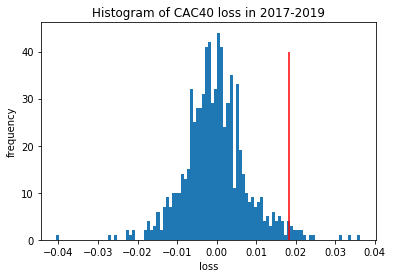

In [5]:
alpha = 0.99

result = result.append(pd.DataFrame([['Gaussian', VaR_Gaussian(loss, alpha), ES_Gaussian(loss, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result.iloc[-1,:])

(no, bins, patches) = plt.hist(loss, bins = 100)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.title('Histogram of CAC40 loss in 2017-2019')
plt.vlines(VaR_Gaussian(loss, alpha), ymin = 0, ymax = 40, color = 'red')

### Nonparametric distribution
The forth method is nonparametrical, the distribution is infered from historical data using kernel method, which usually utilises Gaussian kernel.
\begin{equation}
    \hat{f}(x) = \frac{1}{nh}\sum\limits_{i=1}^n\mathcal{K}\big(\frac{x-x_i}{h}\big)
    \tag{3}
\end{equation}

The estimated density is smoothed by an arbitrary parameter (bandwidth) $h$, greater $h$ resulted in smoother density estimates. 

In [6]:
# estimate empirical density using Gaussian kernel
# inputs: observations X as array; bandwidth (smoothing parameter) h; number of bins
# outputs: support range x; estimated density f
def kernel(x):
    return 1/(2*np.pi)**0.5*np.exp(-x**2/2)
    
def kernel_density(X, h, dx):
    f = []
    x = np.arange(min(X),max(X), dx)

    for i in range(len(x)):
        f.append(np.sum(np.array([kernel((x[i] - r)/h) for r in X])))

    return x, np.array(f)/h/len(X)

def VaR_kernel(X, alpha, h, dx):
    
    x, f = kernel_density(X, h, dx)   
    a = 1
    i = len(x) - 1
    while a >= alpha:
        var = x[i]
        a -= f[i]*dx
        i -= 1
    return var

def ES_kernel(X, alpha, h, dx):
    
    x, f = kernel_density(X, h, dx)
    
    a = 1
    i = len(x) - 1
    es = 0
    while a >= alpha:
        es += x[i]*f[i]*dx
        a -= f[i]*dx
        i -= 1
    return es/(1 - alpha)

Text(0.5, 1.0, 'Kernel density estimate for loss distribution')

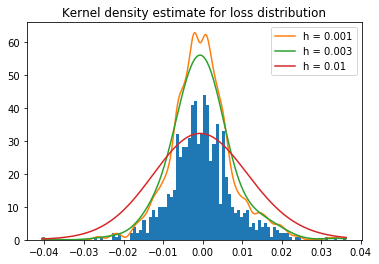

In [7]:
plt.hist(loss, bins = 100)

h = [0.001, 0.003, 0.01]
dx = 0.0001

for h_i in h:
    x, f = kernel_density(loss, h_i, dx)
    plt.plot(x, f)
    
plt.legend(['h = ' + str(h[0]), 'h = ' + str(h[1]), 'h = ' + str(h[2])])
plt.title('Kernel density estimate for loss distribution')

Text(0.5, 1.0, 'VaR as function of bandwidth parameter of the kernel')

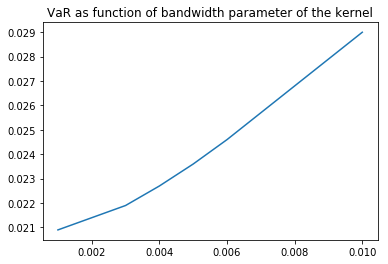

In [8]:
# alpha = 0.99

h = np.arange(0.001, 0.0101, 0.001)

VaR = []
ES = []

for h_i in h:
    VaR.append(VaR_kernel(loss, alpha, h_i, dx))
    ES.append(ES_kernel(loss, alpha, h_i, dx))

plt.plot(h, VaR)
plt.title('VaR as function of bandwidth parameter of the kernel')

In [9]:
result = result.append(pd.DataFrame([['kernel (h = 0.003)', VaR_kernel(loss, alpha, 0.003, dx), ES_kernel(loss, alpha, 0.003, dx)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result.iloc[-1,:])

method    kernel (h = 0.003)
VaR                0.0218963
ES                 0.0270953
Name: 2, dtype: object


### Extreme Value Theory (EVT)

When one needs to evaluate VaR with $\alpha >>$ (99% or even 99.99%), it happens that we usually have so few observations that the usual estimators (discussed above) would be bias. In such case, EVT is a useful tool to tackle this problem. 

We consider a sequence $X_n$ of i.i.d. variables with cdf $F(x)$ and let $Y_n$ be the largest among the variables, its distribution is denoted $F^n(x)$. 

\begin{equation}
    \lim\limits_{n \to \infty} P\Big(\frac{Y_n - b_n}{a_n} \leq x\Big) = \lim\limits_{n \to \infty}F^n(a_nx + b_n) = G(x)
    \tag{4}
\end{equation}

Then $G(x)$ is the extremal distribution function and $F^n(x)$ lies at its domain of attraction (DoA). Consider the generalised extreme value (GEV) distribution which is characterised by 2 parameters: the shape parameter $\xi$ and the scale parameter $\sigma$
\begin{equation}
    G_{\xi, \sigma}(x) = 
    \begin{cases}
        1 - exp\Big(\big(-1+\frac{\xi}{\sigma} x\big)_+^{-1/\xi}\Big) \text{ if } \xi != 0\\
        1 - exp(-e^{-\frac{x}{\sigma}}) \text{ if } \xi = 0
    \end{cases}
    \tag{5}
\end{equation}

This applies for $x>0$ and the scale parameter should be strictly positive $\sigma >0$.

#### Pickand estimator
The following section introduces a widely accepted method to estimate the parameters in GEV method which was introduced by Pickands (1975). In short, they are given by:
\begin{equation}
    \begin{cases}
        \xi = \dfrac{1}{\log(2)}\log\bigg(\dfrac{Z_M - Z_{2M}}{Z_{2M} - Z_{4M}}\bigg) \\
        \sigma = \dfrac{Z_{2M} - Z_{4M}}{\int_0^{log 2} e^{\xi u}du} = \dfrac{\xi}{(2^\xi - 1)}\big(Z_{2M} - Z_{4M}\big)
    \end{cases}
    \tag{6}
\end{equation}

where $Z$ is the descending ordered statistics (the realised losses). $M$ is chosen so as to minimise the maximal "distance" between the empirical upper tail distribution and the extremal distribution. 
\begin{equation}
    d_M = \min\limits_{1 \leq l \leq int(n/4)} \max\limits_{x} \Big|\hat{F_l}(x) - \hat{G_l}(x)\Big|
    \tag{7}
\end{equation}

In [10]:
class EVT:
    import numpy as np
    
    def __init__(self, data, x_range):
        self.data = data
        self.x_range = x_range

# EVT parameters estimator by Pickands (1975)
# input: data as array
# output: xi - shape parameter, sigma - scale parameter, Z_{4M} - location parameter
    def parameters(self):
        def F_l(Z, x, l):
            return 1 - np.array(Z[:4*l-1] - Z[4*l-1] >= x).sum()/4/l

        def G_l(x, xi, sigma):
            if xi == 0:
                    G = 1 - np.exp(-x/sigma)
            elif xi > 0:   
                G = 1 - (1 + xi*x/sigma)**(-1/xi)
            else:
                if x <= sigma/-xi:
                    G = 1 - (1 + xi*x/sigma)**(-1/xi)
                else:
                    G = 1

            return G
        Z = -np.sort(-self.data)
        d_l = []
        for l in range(1, int(len(Z)/4)+1):  
            d = []    
            for x in self.x_range:
                F = F_l(Z, x, l)
                xi = np.log(2)**-1*np.log((Z[l-1] - Z[2*l-1])/(Z[2*l-1] - Z[4*l-1]))
                sigma = (Z[2*l-1] - Z[4*l-1])*xi/(2**xi - 1)
                G = G_l(x, xi, sigma)
                d.append(abs(F-G))
            d_l.append(max(d))
            
        M = np.argmin(np.array(d_l)) + 1
        
        xi = np.log(2)**-1*np.log((Z[M-1] - Z[2*M-1])/(Z[2*M-1] - Z[4*M-1]))
        sigma = (Z[2*M-1] - Z[4*M-1])*xi/(2**xi - 1)

        return xi, sigma, Z[4*M-1]
    
    def VaR(self, alpha):
        
        xi, sigma, u = self.parameters()
        return u + sigma/xi*((len(self.data)/np.array([self.data >= u]).sum()*(1 - alpha))**-xi - 1)
    
    def ES(self, alpha):
        xi, sigma, u = self.parameters()
        return (self.VaR(alpha) + sigma - xi*u)/(1-xi) 


#### VaR and ES from Pickand estimator

Once the parameters are derived, VaR can be calculated directly using the following formula (McNeil 1999):
\begin{equation}
    VaR_\alpha = Z_{4M} + \frac{\sigma}{\xi}\bigg(\Big(\frac{n}{N_{Z_{4M}}}(1-\alpha)\Big)^{-\xi} - 1\bigg)
    \tag{8}
\end{equation}
On the other hand, ES can be deduced as (McNeil 1999):

\begin{align}
    ES_\alpha = \dfrac{VaR_\alpha + \sigma - \xi Z_{4M}}{1 - \xi}
    \tag{9}
\end{align}


In [11]:
evt = EVT(loss, np.arange(0.0101, 0.0501, 0.005))

result = result.append(pd.DataFrame([['EVT: (shape, scale, location) = ' + str(evt.parameters()), evt.VaR(alpha), evt.ES(alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result.iloc[-1,:])

method    EVT: (shape, scale, location) = (-0.0104083962...
VaR                                               0.0219729
ES                                                0.0274938
Name: 3, dtype: object


#### Leadbetter's extremal index for a dataset

Leadbetter's extremal index (1983) is a parameter measuring the degree of extreme clustering in a sample. It is estimated by the reciprocal of the mean cluster size as proposed by Smith & Weissman (1994).
\begin{equation}
    \hat{\theta} = \dfrac{no. clusters}{no. exceedances}
    \tag{10}
\end{equation}

The extremal index affect VaR in the following manner:
\begin{equation}
    VaR_\alpha = Z_{4M} + \frac{\sigma}{\xi}\bigg(\Big(\frac{n}{N_{Z_{4M}}}\theta(1-\alpha)\Big)^{-\xi} - 1\bigg)
    \tag{11}
\end{equation}

In [12]:
# Leadbetter 1983 method for estimating extremal index
# input: data X as array, threshold u, no. of consecutives exceedances k as integer
# output: extremal index theta
def extremal_index(X, u, k):
    exceed = 0
    n_exceed = np.array(X < -u).sum()
    n_cluster = 0
    for i in range(len(X)-k):
        if np.array(X[i:i+k] < -u).sum() == k:
            n_cluster += 1    

    return n_cluster/n_exceed

In [13]:
extremal_index(loss, evt.parameters()[2], 2)

0.5517241379310345

In [210]:
xi, sigma, u = evt.parameters()

var_adj = u + sigma/xi*((len(loss)/np.array([loss >= u]).sum()*(1 - alpha))**-xi - 1)

print('VaR (adj.) = ' , var_adj)
print('ES (adj.) = ' , (var_adj + sigma - xi*u)/(1-xi) )

VaR (adj.) =  0.01693873086850003
ES (adj.) =  0.02088415231347427


### Hurst exponent as a measurement of autocorrelation of a time series

Hurst exponent allows us to distinguish the characteristics of the time series whether it is trending ($H >1/2$) or mean-reverting ($H< 1/2$). This measurement comes along with the concept fractional Brownian motion (fBm) - a generalisation of Brownian motion.

Hurst exponent is often estimated using absolute moment method. The absolute moment of order $k>0$ for the log-price process $S$ observed in time interval $[0, T]$ with $N$ equispaced increments is defined as:
\begin{equation}
    M_{k, N} (S) = \dfrac{1}{N} \sum\limits_{i=1}^N \Big| S_{i\times T/N} - S_{(i-1)\times T/N} \Big|^k
    \tag{11}
\end{equation}

Then the estimator of $H$ is $-1/k$ times the slope of the log-log plot $ln(N)$ $\to$ $\ln(M_{k, N}(S))$

In [14]:
# function estimates Hurst exponent using absolute moment method
# inputs: time series X as array and moment order k
# outputs: Hurst exponent estimate; Moment array M true value; Moment array predicted
def Hurst_estimate(S, N, k):
    M = []
    for n in N:
        s = 0
        for i in range(1,n):
            s += abs(S[i*int(len(S)/n)] - S[(i-1)*int(len(S)/n)])**k

        M.append(1/n*s)

    from sklearn.linear_model import LinearRegression

    regressor = LinearRegression()

    regressor.fit(np.log(N_range).reshape(-1, 1), np.log(M).reshape(-1, 1))

    return regressor.coef_/-k, M, regressor.predict(np.log(N_range).reshape(-1, 1))

Hurst exponent estimate = [[0.53390739]]


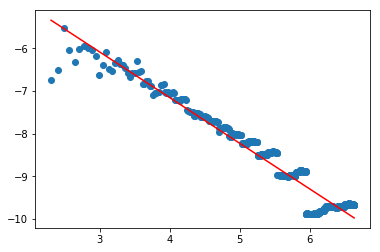

In [15]:
k = 2

S = np.log(np.array(data['Adj Close'].dropna()))
N_range = np.arange(10,len(S)+1)
H, M, M_hat = Hurst_estimate(S, N_range, k)

print('Hurst exponent estimate = ' + str(H))

plt.scatter(np.log(N_range), np.log(M))
plt.plot(np.log(N_range), M_hat, color = 'red')

# 2. VaR distribution under fBm assumption on log-price

We consider Wood-Chan method, or circulant method, to simulate fBm in this project. The Gaussian vector $\xi$ with mean $\mu$ and covariance matrix $C$ can be represented as $\xi = \mu + S\zeta$ where $\zeta$ is a standard Gaussian vector and the matrix is such that $SS^T = C$. As a consequence, the prolem boils down to generating the vector $\zeta$ and the calculation of the "square root" matrix $S$.

The procedure follows the steps as recommended by Shevchenko (2014). In order to simulate $N$ steps of an fBm on the interval $[0, T]$, one needs to calculate the coefficients of the covariance matrix:
\begin{equation}
    \rho_H(n) = \dfrac{1}{2} \Big((n+1)^{2H} + (n-1)^{2H} - 2n^{2H}\Big)
    \tag{12}
\end{equation}

Then the circulant matrix of size $M = 2(N-1)$ is set with coefficients:
\begin{equation}
    \begin{cases}
        c_k = \rho_H(k) \text{ for } k = 1, 2, ..., N-1\\
        c_k = \rho_H(M-k) \text{ for } k = N, N+1, ..., M-1
    \end{cases}    
    \tag{13}
\end{equation}

Take the real part of the inverse FFT (Fast Fourrier Transform) of the standard Gaussian vector $\zeta$ and multiply it with the eigenvalues ${\lambda}_M$ of the above matrix (deduced by FFT method). Next, take the real part of the FFT of the first $N$ elements of the result to get the fGn (fractional Gaussian noise) and multiply them by $(T/N)^H$ to get the increments of fBm. Finally, its cumulative sum would be a simulated path of fBm.

In [16]:
def rho(H, n):
    return 0.5*((n+1)**(2*H) + (n-1)**(2*H) - 2*n**(2*H))

def Lambda(H, N):
    M = 2*N - 2
    c = []
    c.append(1)
    for m in range(1, N):
        c.append(rho(H, m))

    c = c + [0] + c[N-1:0:-1]

    return np.real(np.fft.fft(np.array((c))))**0.5

def fGn(lambd, N):
    w = np.zeros(2*N, dtype=complex)
    
    gn = np.random.normal(size = (N, 1))
    gn2 = np.random.normal(size = (N, 1))
    for i in range(2*N):
        if i == 0:
            w[i] = (lambd[i] / (2 * N))**0.5 * gn[i]
        elif i < N:
            w[i] = (lambd[i] / (4 * N))**0.5 * (gn[i] + 1j * gn2[i])
        elif i == N:
            w[i] = (lambd[i] / (2 * N))**0.5 * gn2[0]
        else:
            w[i] = (lambd[i] / (4 * N))**0.5 * (gn[2 * N - i] - 1j * gn2[2 * N - i])

    # Resulting z is fft of sequence w. Discard small imaginary part (z
    # should be real in theory).
    z = np.fft.fft(w)
    fgn = z[:N].real
    return fgn

def fBm(fGn, H):
    fBm_incr = fGn*(1/(len(fGn)))**H

    fBm = []
    fBm.append(0)
    for i in range(1,len(fGn)):
        fBm.append(np.array(fBm_incr[:i]).sum())
                   
    return fBm

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  2.,  1.,  0.,  5.,
         5.,  3.,  2.,  5., 10.,  4.,  2.,  6.,  3.,  7.,  5.,  2.,  4.,
         2.,  1.,  2.,  3.,  4.,  4.,  0.,  3.,  2.,  1.,  2.,  0.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00070306, 0.00071576, 0.00072846, 0.00074116, 0.00075386,
        0.00076656, 0.00077926, 0.00079196, 0.00080466, 0.00081736,
        0.00083006, 0.00084276, 0.00085546, 0.00086816, 0.00088086,
        0.00089356, 0.00090626, 0.00091896, 0.00093166, 0.00094436,
        0.00095706, 0.00096976, 0.00098246, 0.00099516, 0.00100786,
        0.00102056, 0.00103326, 0.00104596, 0.00105866, 0.00107136,
        0.00108406, 0.00109676, 0.00110946, 0.00112216, 0.00113486,
        0.00114756, 0.00116026, 0.00117296, 0.00118566, 0.00119836,
        0.00121106, 0.00122376, 0.00123646, 0.00124916, 0.00126186,
        0.00127456, 0.00128726, 0.00129996, 0.00131266, 0.00132536,
        0.00133806]),
 <a list of 50

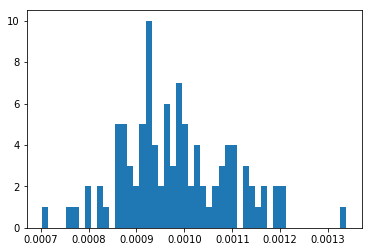

In [17]:
H = 0.53390739
N = 250

L = Lambda(H, N)
muy = loss.mean()
sigma = loss.std()
dt = 1/N

VaR = []
for n in range(100):
    Gn = fGn(L, N)
    l = (muy - 0.5*sigma**2)*dt + sigma*Gn*(1/(len(Gn)))**H
    evt = EVT(l, np.arange(0.0101, 0.0501, 0.005))
    VaR.append(evt.VaR(0.99))

plt.hist(VaR, bins = 50)

# 3. Backtesting

Having discussed the common methodologies for estimating VaR, this part dedicates to evaluating the precision of each estimator. This section encompasses 3 common tests: the standard coverage test, the distribution test and the independence test.

### Standard coverage test

Coverage test is a hypothesis test if the actual frequency of exceedances $q^*$ equals (or greater than) the presumed frequency $q$ (where $q = 1-\alpha$). 
\begin{equation}
    \mathcal{H}_0: q^* = q
\end{equation}
The number of exceedances $X$ (# obs. loss > VaR) is a binomial variable, i.e. $X \sim \mathcal{B}(\text{ no. of obs.}, 1-\alpha)$. 
\begin{equation}
    X = \sum 1_{loss > VaR}
\end{equation}

The number of observations here is set to 1-year (250 days), that is the time window for backtesting. At significance level $\epsilon$ we accept the null hypothesis if the number of exceedances is in the interval $[x_1, x_2]$ such that:
\begin{equation}
    P\big(X \in [x_1, x_2]\big) > 1 - \epsilon
\end{equation}

In [105]:
# Perform two-sided test of the null hypothesis that the probability of success in a Bernoulli experiment is p.
# inputs: realised loss (array) in backtesting sample, 1-day VaR (array) same dimension
# return 
def standard_coverage_test(loss, VaR, alpha, significance_level):
    from statsmodels.stats.proportion import proportion_confint
    
    exceedance = np.array(loss > VaR).sum()
    low, high = proportion_confint(exceedance, len(loss), significance_level)
    q = 1-alpha
    
    if (q >= low) & (q <= high):
        print('Accept null hypothesis')
    else:
        print('Reject null hypothesis')
        
    return low, high

### Distribution test

This test checks the normality assumption about the loss distribution. From graphical view point, the loss distribution disperses widely at both ends of the distribution. When calculating sample correlation between the loss distribution and the quantile of normal distribution, it yields 0.047 which is a small value. This indicates dissimilarity between two distributions.

corr = 0.047264269200366506


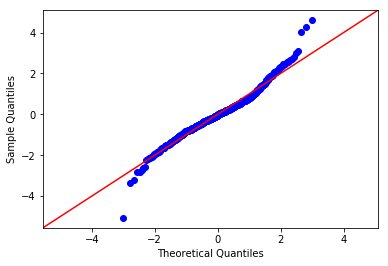

In [122]:
from statsmodels.graphics.gofplots import qqplot

qqplot(loss, line = '45', fit = True)

def Filliben_test(data):
    from scipy.special import erfinv
    
    n = len(data)
    x = []
    for j in range(1, len(data)+1):
        x.append(2**0.5 * erfinv(2*((j - 0.5)/len(data)) - 1))
    
    return np.corrcoef(np.array(x), data)[0,1]

print('corr = ' + str(Filliben_test(loss[-250:])))

### Exceedance's Independence test

Christoffersen’s (1998) independence test is a likelihood ratio test that looks for unusually frequent consecutive exceedances—i.e. instances when both $i^{t–1} = 1$ and $i^t = 1$ for some t. The test is well known, since it was first proposed in an often-cited endorsement of testing for independence of exceedances.

In [137]:
def independence_test(loss, VaR):
    import numpy as np
    
    x = np.array(loss > VaR)*1
    x1 = np.roll(x, 1)[1:]
    
    a_00 = np.array([x[1:] + x1 == [0] * (len(x) - 1)]).sum()
    a_11 = np.array([x[1:] + x1 == [2] * (len(x) - 1)]).sum()
    
    a_01 = np.array([x[1:] - x1 == [-1] * (len(x) - 1)]).sum()
    a_10 = np.array([x[1:] - x1 == [1] * (len(x) - 1)]).sum()
    
    q0 = a_00/(a_00 + a_01)
    q1 = a_10/(a_10 + a_11)
    q = (a_00 + a_01) / (a_00 + a_01 + a_10 + a_11)
    
    L = (q/q0)**a_00 * ((1-q)/(1-q0))**a_01 * (q/q1)**a_10 * ((1-q)/(1-q1))**a_11
    
    critical_range = {'1%': 6.635, '5%': 3.841}
    return -2*np.log(L), critical_range

Backtesting the calculated VaR from the above-mentioned methods, the parametric Gaussian method is rejected at 5% of significance level for coverage test. Meanwhile, empirical quantile and parametric Gaussian method do not pass independence test at 5% significant level.

In [139]:
# backtesting for empirical quantile method
VaR = []
for i in range(512, len(loss)):
    VaR.append(VaR_quantile(loss[:i+1], alpha))
    
print('empirical quantile: ')
print(standard_coverage_test(loss[-250:], VaR, alpha, 0.05))

independence_test(loss[-250:], VaR)

empirical quantile: 
Accept null hypothesis
(0.0026457390954722736, 0.03735426090452773)


(3.153989286651423, {'1%': 6.635, '5%': 3.841})

In [140]:
# backtesting for parametric Gaussian method
VaR = []
for i in range(512, len(loss)):
    VaR.append(VaR_Gaussian(loss[:i+1], alpha))
    
print('parametric Gaussian: ')
print(standard_coverage_test(loss[-250:], VaR, alpha, 0.05))

independence_test(loss[-250:], VaR)

parametric Gaussian: 
Reject null hypothesis
(0.01290766474231166, 0.05909233525768834)


(1.0063610339314302, {'1%': 6.635, '5%': 3.841})

In [141]:
# backtesting for kernel method
VaR = []
for i in range(512, len(loss)):
    VaR.append(VaR_kernel(loss[:i+1], alpha, 0.003, dx))
    
print('kernel: ')
print(standard_coverage_test(loss[-250:], VaR, alpha, 0.05))

independence_test(loss[-250:], VaR)

kernel: 
Accept null hypothesis
(0.0, 0.025497308735914662)


(5.425235005524173, {'1%': 6.635, '5%': 3.841})

In [142]:
# backtesting for EVT method
VaR = []
for i in range(512, len(loss)):
    evt = EVT(loss[:i+1], np.arange(0.0101, 0.0501, 0.005))
    VaR.append(evt.VaR(alpha))
    
print('EVT: ')
print(standard_coverage_test(loss[-250:], VaR, alpha, 0.05))

independence_test(loss[-250:], VaR)

EVT: 
Accept null hypothesis
(0.0004462316240715046, 0.03155376837592849)


(4.106993251527207, {'1%': 6.635, '5%': 3.841})

The dataset passes the independence test at 5% significance level.

# 4. Robustness of VaR estimators

This section studies the impact of noise on VaR measures by two means: (i) adding noise to or (ii) removing noise from the price return process.

### Adding noise to price return series

In [153]:
z = np.random.normal(scale = loss.std(), size = len(loss))

loss2 = loss + z

alpha = 0.99

result2 = pd.DataFrame(columns = ['method', 'VaR', 'ES'])
result2 = result2.append(pd.DataFrame([['empirical', VaR_quantile(loss2, alpha), ES_quantile(loss2, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result2 = result2.append(pd.DataFrame([['Gaussian', VaR_Gaussian(loss2, alpha), ES_Gaussian(loss2, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result2 = result2.append(pd.DataFrame([['kernel (h = 0.003)', VaR_kernel(loss2, alpha, 0.003, dx), ES_kernel(loss2, alpha, 0.003, dx)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

evt = EVT(loss2, np.arange(0.0101, 0.0501, 0.005))
result2 = result2.append(pd.DataFrame([['EVT: (shape, scale, location) = ' + str(evt.parameters()), evt.VaR(alpha), evt.ES(alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result)
print(result2)

                                              method       VaR        ES
0                                          empirical  0.020694  0.026793
1                                           Gaussian  0.018264  0.020963
2                                 kernel (h = 0.003)  0.021896  0.027095
3  EVT: (shape, scale, location) = (-0.0104083962...  0.021973  0.027494
                                              method       VaR        ES
0                                          empirical  0.027455  0.032162
1                                           Gaussian  0.026356  0.030217
2                                 kernel (h = 0.003)  0.028398  0.032752
3  EVT: (shape, scale, location) = (-0.1702500472...  0.028392  0.032589


Compare the percentage change of VaR of each method, kernel and EVT method are stabler than the other two (empirical quantile and parametric Gaussian). VaR diameter also shrinks by 45%.

In [157]:
change = result2.VaR/result.VaR - 1
VaR_diameter = np.array([result.VaR.max() - result.VaR.min(), result2.VaR.max() - result2.VaR.min()])

print(change)
print(VaR_diameter)

0    0.326713
1    0.443054
2    0.296921
3    0.292134
Name: VaR, dtype: float64
[0.00370883 0.00204162]


### Removing noise from price return series

The method of use here if the wavelet transform. Haar and Daubechies4 scale functions are applied to denoise the loss time series.

In [192]:
class Haar:
    import numpy as np
    import matplotlib.pyplot as plt

    def direct(self, f , scale):
        N = len(f)
        max_length = 2**(int(np.log2(len(f))) + 1)
        max_scale = int(np.log2(len(f))) + 1

        if np.log2(len(f)) - int(np.log2(len(f))) != 0:
            f = np.pad(f, (0, max_length - N -1), mode = 'constant')

        d = []
        for i in range(min(max_scale, scale)):
            d1 = f[1::2] - f[:len(f)-1:2]
            s1 = f[:len(d1)*2:2] + 0.5*d1
            f = 2**0.5*s1
            di = 2**-0.5*d1
            d.append(di)

        return f, np.array(d)

    def inverse(self, s, d, scale):
        max_scale = len(d)
        for i in range(min(max_scale,scale)):
            d1 = 2**0.5*np.array(d[scale - i - 1])
            s1 = 2**-0.5*s
#             f = np.zeros(len(s)*2)
#             f[::2] = s1 - 0.5*d1
#             f[1::2] = f[::2] + d1
            f = []
            for n in range(0, len(s)):
                f.append(s1[n] - 0.5*d1[n])
                f.append(f[2*n] + d1[n])

            s = np.array(f)        
        return s
    
    def multiresolution(self, f, scale):
        s, d = self.direct(f, scale)

        s_prime = []
        for i in range(scale):
            d_prime = []
            for j in range(scale):
                if j == i:
                    d_prime.append(d[i])
                else:
                    d_prime.append([0] * len(d[j]))

            s_prime.append(self.inverse(np.zeros(len(s)), np.array(d_prime), scale))

        s_prime.append(self.inverse(s, [[0] * np.array(di) for di in d], scale))

        return s_prime

    def plot(self, X):
        N = len(X)
        fig, axs = plt.subplots(N)
        
        for i in range(N):
            axs[i].plot(np.array(X[i]))

        plt.tight_layout()
        plt.show()

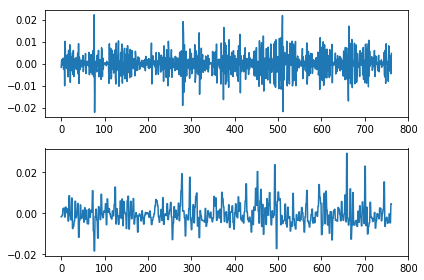

In [198]:
f = loss
dwt = Haar()

s = dwt.multiresolution(f.values, scale = 1)

n = len(f.index)
L = [si[:n] for si in s]
dwt.plot(L)


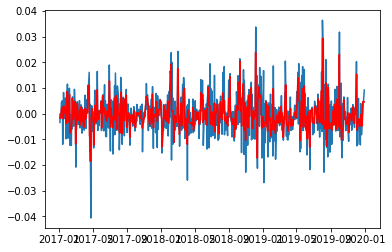

In [199]:
signal = L[0]
for i in range(1, len(L)):
    signal += L[i]

    
plt.plot(f)    
plt.plot(f.index, L[-1], color = 'red')

Having remove the noise from the loss series, similar procedure is taken to compare this denoised process with the original one. Again, kernel and EVT method are the stabler methods. VaR diameter diminishes by roughly 70%.

In [201]:
alpha = 0.99

loss3 = L[-1]

result3 = pd.DataFrame(columns = ['method', 'VaR', 'ES'])
result3 = result3.append(pd.DataFrame([['empirical', VaR_quantile(loss3, alpha), ES_quantile(loss3, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result3 = result3.append(pd.DataFrame([['Gaussian', VaR_Gaussian(loss3, alpha), ES_Gaussian(loss3, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result3 = result3.append(pd.DataFrame([['kernel (h = 0.003)', VaR_kernel(loss3, alpha, 0.003, dx), ES_kernel(loss3, alpha, 0.003, dx)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

evt = EVT(loss3, np.arange(0.0001, 0.0501, 0.005))
result3 = result3.append(pd.DataFrame([['EVT: (shape, scale, location) = ' + str(evt.parameters()), evt.VaR(alpha), evt.ES(alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result)
print(result3)

change2 = result3.VaR/result.VaR - 1
VaR_diameter2 = np.array([result.VaR.max() - result.VaR.min(), result3.VaR.max() - result3.VaR.min()])

print(change2)
print(VaR_diameter2)

                                              method       VaR        ES
0                                          empirical  0.020694  0.026793
1                                           Gaussian  0.018264  0.020963
2                                 kernel (h = 0.003)  0.021896  0.027095
3  EVT: (shape, scale, location) = (-0.0104083962...  0.021973  0.027494
                                              method       VaR        ES
0                                          empirical  0.019713  0.024077
1                                           Gaussian  0.013424  0.015418
2                                 kernel (h = 0.003)  0.019444  0.023647
3  EVT: (shape, scale, location) = (-0.0204271622...  0.018408  0.023102
0   -0.047384
1   -0.264993
2   -0.112003
3   -0.162242
Name: VaR, dtype: float64
[0.00370883 0.00628919]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [206]:
class Daubechies4:
    import numpy as np
    import matplotlib.pyplot as plt

    def direct(self, f , scale):
        N = len(f)
        max_length = 2**(int(np.log2(len(f))) + 1)
        max_scale = int(np.log2(len(f))) + 1

        if np.log2(len(f)) - int(np.log2(len(f))) != 0:
            f = np.pad(f, (0, max_length - N -1), mode = 'constant')

        d = []
        for i in range(min(max_scale, scale)):
            d1 = f[1::2] - f[:len(f)-1:2]
            s1 = f[:len(f)-1:2] + 0.5*d1
            f = 2**0.5*s1
            di = 2**-0.5*d1
            d.append(di)

        return f, np.array(d)

    def inverse(self, s, d, scale):
        max_scale = len(d)
        for i in range(min(max_scale,scale)):
            d1 = np.array(d[scale - i - 1]) / (3**0.5 + 1) * 2**0.5
            s2 = s / (3**0.5 - 1) * 2**0.5
            s1 = s2 + np.roll(d1, 1)
            f = np.zeros(2*len(s) + 1)
            f[1::2] = d1 + 3**0.5*0.25*s1 + (3**0.5 - 2)*0.25*np.roll(s1, -1)
            f[:len(s)*2:2] = s1 - 3**0.5*f[1::2]
            s = np.array(f)
        return s
    
    def multiresolution(self, f, scale):
        N = len(f)
        s, d = self.direct(f, scale)
        
        s_prime = []
        for i in range(scale):
            d_prime = []
            for j in range(scale):
                if j == i:
                    d_prime.append(d[i])
                else:
                    d_prime.append([0] * len(d[j]))

            s_prime.append(self.inverse(np.zeros(len(s)), np.array(d_prime), scale)[:N])

        s_prime.append(self.inverse(s, [[0] * np.array(di) for di in d], scale)[:N])

        return s_prime

    def plot(self, X):
        N = len(X)
        fig, axs = plt.subplots(N)
        
        for i in range(N):
            axs[i].plot(np.array(X[i]))

        plt.tight_layout()
        plt.show()
        

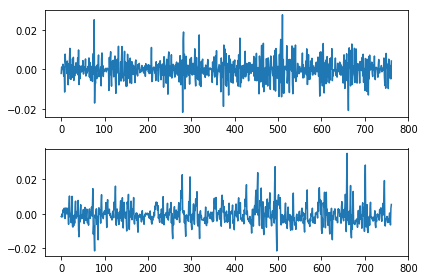

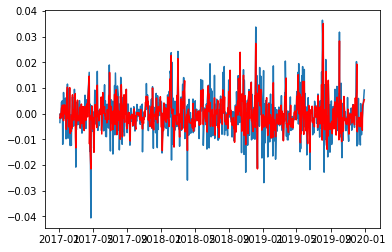

In [207]:
f = loss
dwt = Daubechies4()

s = dwt.multiresolution(f.values, scale = 1)

n = len(f.index)
L = [si[:n] for si in s]
dwt.plot(L)

signal = L[0]
for i in range(1, len(L)):
    signal += L[i]

    
plt.plot(f)    
plt.plot(f.index, L[-1], color = 'red')

In [208]:
alpha = 0.99

loss4 = L[-1]

result4 = pd.DataFrame(columns = ['method', 'VaR', 'ES'])
result4 = result4.append(pd.DataFrame([['empirical', VaR_quantile(loss4, alpha), ES_quantile(loss4, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result4 = result4.append(pd.DataFrame([['Gaussian', VaR_Gaussian(loss4, alpha), ES_Gaussian(loss4, alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

result4 = result4.append(pd.DataFrame([['kernel (h = 0.003)', VaR_kernel(loss4, alpha, 0.003, dx), ES_kernel(loss4, alpha, 0.003, dx)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

evt = EVT(loss4, np.arange(0.0001, 0.0501, 0.005))
result4 = result4.append(pd.DataFrame([['EVT: (shape, scale, location) = ' + str(evt.parameters()), evt.VaR(alpha), evt.ES(alpha)]], 
                                    columns = ['method', 'VaR', 'ES']), ignore_index = True)

print(result)
print(result4)

change3 = result4.VaR/result.VaR - 1
VaR_diameter3 = np.array([result.VaR.max() - result.VaR.min(), result4.VaR.max() - result4.VaR.min()])

print(change3)
print(VaR_diameter3)

                                              method       VaR        ES
0                                          empirical  0.020694  0.026793
1                                           Gaussian  0.018264  0.020963
2                                 kernel (h = 0.003)  0.021896  0.027095
3  EVT: (shape, scale, location) = (-0.0104083962...  0.021973  0.027494
                                              method       VaR        ES
0                                          empirical  0.018154  0.024638
1                                           Gaussian  0.013424  0.015418
2                                 kernel (h = 0.003)  0.019075  0.024495
3  EVT: (shape, scale, location) = (-0.0587778561...  0.017163  0.021096
0   -0.122761
1   -0.264980
2   -0.128833
3   -0.218908
Name: VaR, dtype: float64
[0.00370883 0.00565081]


# References

[1] Holton, G.A., Value-at-Risk: Theory and Practice, 2nd edition (2014) 

[2] Jensen, A. and la Cour-Harbo, A., Ripples in Mathematics The Discrete Wavelet Transform, Springer (2001)

[3] McNeil, A.J., Extreme Value Theory for Risk Managers (1999)

[4] Leadbetter, M.R., On Clustering of High Values in Statistically Stationary Series, Siam Institute for Mathematics and Society (1990)

[5] Saap, T.A.R., Efficient Estimation of Distributional Tail Shape and the Extremal Index with Applications to Risk Management, Journal of Mathematical Finance (2016)

[6] Shevchenko, G., Fractional Brownian Motion in a Nutshell, Lecture Notes (2014)

[7] Pickands, J., Statistical Inference Using Extreme Order Statistics, Institute of Mathematical Statistics (1975)